In [1]:
from tanke_dodge import TankDodge
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import pygame

/home/anky/Github/RL/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/dqn_tank_dodge')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class VfApproxModel(nn.Module):
    """Neural Network for Value Function Approximation
    Contains Three layers (state_size)->10->10->4
    """
    def __init__(self, state_size):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=state_size, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=4) # 4 actions as output
        self.relu = nn.ReLU()
    
    def forward(self, features):
        out = self.relu(self.layer_1(features))
        out = self.relu(self.layer_2(out))
        out = self.layer_3(out)
        return out

In [5]:
class Agent:
    def __init__(self, replay_length, learning_rate, epsilon, max_epsilon, min_epsilon, epsilon_decay, gamma, action_size, value_function):
        self.replay_memory = deque(maxlen=replay_length)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.action_size = action_size
        self.value_function = value_function
        self.loss_fn = nn.SmoothL1Loss().to(device)
        self.opt  = torch.optim.AdamW(value_function.parameters(), lr=learning_rate, amsgrad=True)
        self.epsilon_list = []
        self.losses =  []

    def add_experience(self, new_state, reward, running, state, action):
        self.replay_memory.append((new_state, reward, running, state, action))
    
    def action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_size)
        out = self.value_function(state)
        out = out.cpu().detach().numpy()
        return np.argmax(out)
    
    def greedy_action(self, state):
        out = self.value_function(state)
        out = out.cpu().detach().numpy()
        return np.argmax(out)
    
    def replay(self, batch_size, episode):
        batch = random.sample(self.replay_memory, batch_size)
        losses = []
        for new_state, reward, running, state, action in batch:
            q_values = self.value_function(state)
            q_value = q_values[0, action]  # <-- FIXED: correct indexing
            with torch.no_grad():
                next_q_values = self.value_function(new_state)
                max_next_q = torch.max(next_q_values)
                target = reward + self.gamma * max_next_q * float(running)
            loss = self.loss_fn(q_value, target)
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            losses.append(loss.item())
        return np.mean(losses) if losses else 0.0

    def save_weights(self, path):
        torch.save(self.value_function.state_dict(), path)

In [6]:
env = TankDodge(num_enemies=3)
state_size = 2 + 2 * env.num_enemies  # [tank_x, tank_y, enemy1_x, enemy1_y, ...]
value_function = VfApproxModel(state_size)
value_function.to(device)

VfApproxModel(
  (layer_1): Linear(in_features=8, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=4, bias=True)
  (relu): ReLU()
)

In [7]:
num_episodes = 10000
learning_rate = 0.0001
discount_factor = 0.99
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.04
exploration_decay_rate = 0.01
replay_length = 5000
batch_size = 128

agent = Agent(
    replay_length=replay_length,
    learning_rate=learning_rate,
    epsilon=exploration_rate,
    max_epsilon=max_exploration_rate,
    min_epsilon=min_exploration_rate,
    epsilon_decay=exploration_decay_rate,
    gamma=discount_factor,
    action_size=4,
    value_function=value_function
)

In [8]:
losses_per_episode = []
rewards_history = []
for episode in range(num_episodes):
    print(f"-----Episode: [{episode+1}/{num_episodes}]-----")
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # <-- FIXED: add batch dim
    running = True
    actions_taken_per_episode = 0
    rewards_per_episode = 0
    steps = 0
    while running:
        torch.cuda.empty_cache()
        action = agent.action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)  # <-- FIXED
        agent.add_experience(next_state, reward, not done, state, action)
        state = next_state
        rewards_per_episode += reward
        actions_taken_per_episode += 1
        running = not done
        steps += 1

    agent.epsilon = (agent.max_epsilon-agent.min_epsilon) * np.exp(-agent.epsilon_decay*episode) + agent.min_epsilon
    pygame.display.quit()

    if len(agent.replay_memory) > batch_size:
        replay_loss = agent.replay(batch_size, episode)
        writer.add_scalar("Replay Loss", replay_loss, episode)
    
    writer.add_scalar("Reward per Episode", rewards_per_episode, episode)
    writer.add_scalar("Actions Taken per Episode", actions_taken_per_episode, episode)
    writer.add_scalar("Epsilon per episode", agent.epsilon, episode)
    print(f"Reward:{rewards_per_episode}")
    print(f"Actions Taken:{actions_taken_per_episode}")
    rewards_history.append(rewards_per_episode)

writer.close()
agent.save_weights("saved_weights/last_episode_weights.pth")

-----Episode: [1/10000]-----
Reward:127
Actions Taken:178
-----Episode: [2/10000]-----
Reward:144
Actions Taken:195
-----Episode: [3/10000]-----
Reward:194
Actions Taken:245
-----Episode: [4/10000]-----
Reward:111
Actions Taken:162
-----Episode: [5/10000]-----
Reward:115
Actions Taken:166
-----Episode: [6/10000]-----
Reward:251
Actions Taken:302
-----Episode: [7/10000]-----
Reward:120
Actions Taken:171
-----Episode: [8/10000]-----
Reward:154
Actions Taken:205
-----Episode: [9/10000]-----
Reward:98
Actions Taken:149
-----Episode: [10/10000]-----
Reward:147
Actions Taken:198
-----Episode: [11/10000]-----
Reward:158
Actions Taken:209
-----Episode: [12/10000]-----
Reward:114
Actions Taken:165
-----Episode: [13/10000]-----
Reward:107
Actions Taken:158
-----Episode: [14/10000]-----
Reward:224
Actions Taken:275
-----Episode: [15/10000]-----
Reward:122
Actions Taken:173
-----Episode: [16/10000]-----
Reward:151
Actions Taken:202
-----Episode: [17/10000]-----
Reward:105
Actions Taken:156
-----Ep

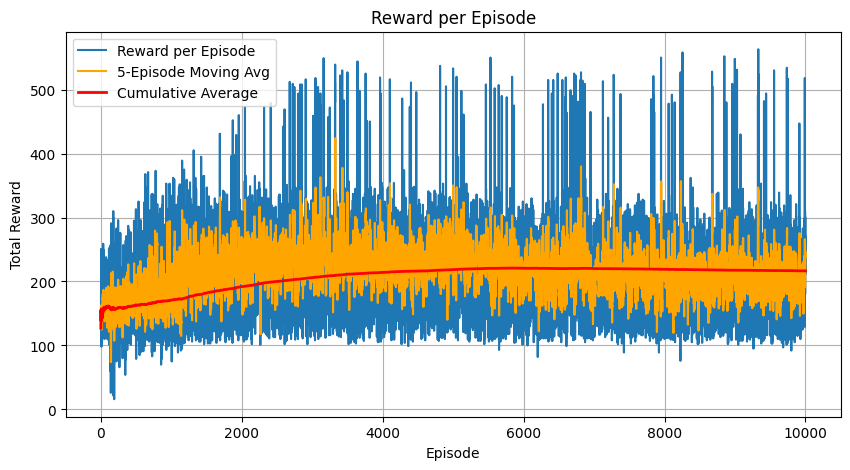

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="Reward per Episode")

# Moving average (window=5)
if len(rewards_history) >= 5:
    avg5 = np.convolve(rewards_history, np.ones(5)/5, mode='valid')
    plt.plot(range(4, len(rewards_history)), avg5, label="5-Episode Moving Avg", color='orange')

# Global mean (cumulative average)
global_mean = np.cumsum(rewards_history) / (np.arange(len(rewards_history)) + 1)
plt.plot(global_mean, label="Cumulative Average", color='red', linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode")
plt.grid()
plt.legend()
plt.show()